<a href="https://colab.research.google.com/github/superbunny38/MachineLearning/blob/main/CS229MachineLearning/2022AndrewLectureNotes/Probset1/Prob1/Set1Problem1(e).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Rights:**

*Assignment made by: Prof. Andrew Ng, Stanford*

*Assignment solved by: Chaeeun Ryu, SKKU*

# Prob 1. (e)
Fill in the code to calculate $Φ$, $\mu_0$, $\mu_1$, and $Σ$, use these parameters to derive $θ$ and use the resulting GDA model to make predictions on the validation set.

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Check data

In [11]:
train_df = pd.read_csv('/content/ds2_train.csv')
train_df.head()

,x_1,x_2,y
0,3.759481,7.507940,0.0
1,3.422057,4.991203,0.0
2,2.778818,4.112071,0.0
3,4.018066,5.653732,0.0
4,1.806062,4.685966,0.0


# Linear Models

In [2]:
class LinearModel(object):
    """Base class for linear models."""

    def __init__(self, step_size=0.2, max_iter=100, eps=1e-5,
                 theta_0=None, verbose=True):
        """
        Args:
            step_size: Step size for iterative solvers only.
            max_iter: Maximum number of iterations for the solver.
            eps: Threshold for determining convergence.
            theta_0: Initial guess for theta. If None, use the zero vector.
            verbose: Print loss values during training.
        """
        self.theta = theta_0
        self.step_size = step_size
        self.max_iter = max_iter
        self.eps = eps
        self.verbose = verbose

    def fit(self, x, y):
        """Run solver to fit linear model.

        Args:
            x: Training example inputs. Shape (m, n).
            y: Training example labels. Shape (m,).
        """
        raise NotImplementedError('Subclass of LinearModel must implement fit method.')

    def predict(self, x):
        """Make a prediction given new inputs x.

        Args:
            x: Inputs of shape (m, n).

        Returns:
            Outputs of shape (m,).
        """
        raise NotImplementedError('Subclass of LinearModel must implement predict method.')

# Utils

In [1]:
import matplotlib.pyplot as plt
import numpy as np


def add_intercept(x):
    """Add intercept to matrix x.

    Args:
        x: 2D NumPy array.

    Returns:
        New matrix same as x with 1's in the 0th column.
    """
    new_x = np.zeros((x.shape[0], x.shape[1] + 1), dtype=x.dtype)
    new_x[:, 0] = 1
    new_x[:, 1:] = x

    return new_x


def load_dataset(csv_path, label_col='y', add_intercept=False):
    """Load dataset from a CSV file.

    Args:
         csv_path: Path to CSV file containing dataset.
         label_col: Name of column to use as labels (should be 'y' or 'l').
         add_intercept: Add an intercept entry to x-values.

    Returns:
        xs: Numpy array of x-values (inputs).
        ys: Numpy array of y-values (labels).
    """

    def add_intercept_fn(x):
        global add_intercept
        return add_intercept(x)

    # Validate label_col argument
    allowed_label_cols = ('y', 't')
    if label_col not in allowed_label_cols:
        raise ValueError('Invalid label_col: {} (expected {})'
                         .format(label_col, allowed_label_cols))

    # Load headers
    with open(csv_path, 'r') as csv_fh:
        headers = csv_fh.readline().strip().split(',')

    # Load features and labels
    x_cols = [i for i in range(len(headers)) if headers[i].startswith('x')]
    l_cols = [i for i in range(len(headers)) if headers[i] == label_col]
    inputs = np.loadtxt(csv_path, delimiter=',', skiprows=1, usecols=x_cols)
    labels = np.loadtxt(csv_path, delimiter=',', skiprows=1, usecols=l_cols)

    if inputs.ndim == 1:
        inputs = np.expand_dims(inputs, -1)

    if add_intercept:
        inputs = add_intercept_fn(inputs)

    return inputs, labels


def plot(x, y, theta, save_path=None, correction=1.0):
    """Plot dataset and fitted logistic regression parameters.
    Args:
        x: Matrix of training examples, one per row.
        y: Vector of labels in {0, 1}.
        theta: Vector of parameters for logistic regression model.
        save_path: Path to save the plot.
        correction: Correction factor to apply (Problem 2(e) only).
    """
    # Plot dataset
    plt.figure()
    plt.plot(x[y == 1, -2], x[y == 1, -1], 'bx', linewidth=2)
    plt.plot(x[y == 0, -2], x[y == 0, -1], 'go', linewidth=2)

    # Plot decision boundary (found by solving for theta^T x = 0)
    margin1 = (max(x[:, -2]) - min(x[:, -2]))*0.2
    margin2 = (max(x[:, -1]) - min(x[:, -1]))*0.2
    x1 = np.arange(min(x[:, -2])-margin1, max(x[:, -2])+margin1, 0.01)
    x2 = -(theta[0] / theta[2] * correction + theta[1] / theta[2] * x1)
    plt.plot(x1, x2, c='red', linewidth=2)
    plt.xlim(x[:, -2].min()-margin1, x[:, -2].max()+margin1)
    plt.ylim(x[:, -1].min()-margin2, x[:, -1].max()+margin2)

    # Add labels and save to disk
    plt.xlabel('x1')
    plt.ylabel('x2')
    if save_path is not None:
        plt.savefig(save_path)

In [119]:
import math
def sigmoid(z):
  result = 1/(1+np.exp(-z))
  return result

In [74]:
def convert_numpy(x):
  list_ = []
  for _ in x:
    list_.append(np.array(_))
  return list_[0],list_[1],list_[2], list_[3]

In [89]:
def acc(h,y):
  as_labels = []
  for _ in h:
    if _ > 0.5:
      as_labels.append(1.)
    elif _ <= 0.5:
      as_labels.append(0.)
  as_labels, y = np.array(as_labels), np.array(y)
  #print(as_labels)
  return (as_labels == y).sum()/len(as_labels)

In [155]:
import numpy as np


def main(train_path = "/content/ds2_train.csv", eval_path = "/content/ds2_valid.csv", pred_path = None):
    """Problem 1(e): Gaussian discriminant analysis (GDA)

    Args:
        train_path: Path to CSV file containing dataset for training.
        eval_path: Path to CSV file containing dataset for evaluation.
        pred_path: Path to save predictions.
    """
    # Load dataset
    x_train, y_train = load_dataset(train_path, add_intercept=False)
    print(f"train dataset loaded (x: {x_train.shape}, y: {y_train.shape})")
    
    # *** START CODE HERE ***
    clf = GDA()
    phi, mu_0, mu_1, sigma = clf.fit(x_train, y_train)
    #print(f"params: {phi, mu_0, mu_1, sigma}")
    predicted=[]
    for x_ in x_train:
      pred = clf.predict(x_)
      predicted.append(pred)
    train_acc = acc(predicted, y_train)
    print(f"train_acc: {train_acc}")




    # Validation dataset
    x_val, y_val = load_dataset(eval_path, add_intercept= False)
    print(f"eval dataset loaded (x: {x_val.shape}, y: {y_val.shape})")
    predicted_val = []
    for x_ in x_val:
      pred = clf.predict(x_)
      predicted_val.append(pred)
    val_acc = acc(predicted_val, y_val)
    print(f"val_acc: {val_acc}")
    
    #return phi, mu_0, mu_1, sigma
    return predicted, predicted_val, clf#predictions for train dset & validation dset
    # *** END CODE HERE ***


class GDA(LinearModel):
    """Gaussian Discriminant Analysis.

    Example usage:
        > clf = GDA()
        > clf.fit(x_train, y_train)
        > clf.predict(x_eval)

    """
    def __init__(self, phi = None, mu_0 = None, mu_1 = None, sigma = None, theta = None, theta_0 = None):
      self.phi = phi
      self.mu_0 = mu_0
      self.mu_1 = mu_1
      self.sigma = sigma
      self.theta = theta
      self.theta_0 = theta_0

    def fit(self, x, y):
        """Fit a GDA model to training set given by x and y.

        Args:
            x: Training example inputs. Shape (m, n).
            y: Training example labels. Shape (m,).

        Returns:
            theta: GDA model parameters.
        """
        # *** START CODE HERE ***
        m = len(y)
        x_train, y_train = x,y
        assert m == x.shape[0]
        phi = np.array(np.where(y_train == 1)).shape[1]/m
        zero_indices = np.array(np.where(y_train == 0))[0]
        mu_0 =np.sum(x_train[zero_indices],axis = 0)/len(np.array(np.where(y_train == 0))[0])
        one_indices = np.array(np.where(y_train == 1))[0]
        mu_1 = np.sum(x_train[one_indices],axis = 0)/len(np.array(np.where(y_train == 1))[0])
        sum_sigma = 0
        for x_, y_ in zip(x, y):
          x_ = np.array(x_)
          if y_ == 1:
            tmp = x_-mu_1
            tmp = np.array(tmp).reshape(-1,1)
            sum_sigma += np.matmul(tmp, tmp.T)
          elif y_ == 0:
            tmp = x_ - mu_0
            tmp = np.array(tmp).reshape(-1,1)
            sum_sigma += np.matmul(tmp, tmp.T)
        sigma = sum_sigma/m
        self.phi = phi
        self.mu_0 = mu_0
        self.mu_1 = mu_1
        self.sigma = sigma
        
  
        return phi, mu_0, mu_1, sigma
        # *** END CODE HERE ***

    def predict(self, x):
        """Make a prediction given new inputs x.

        Args:
            x: Inputs of shape (m, n).

        Returns:
            Outputs of shape (m,).
        """
        

        # *** START CODE HERE ***
        phi, mu_0, mu_1, sigma = self.phi, self.mu_0, self.mu_1, self.sigma
        phi, mu_0, mu_1, sigma = convert_numpy([phi, mu_0, mu_1, sigma])
        mu_0, mu_1 = mu_0.reshape(-1,1),mu_1.reshape(-1,1)
       
        theta_transpose = -np.matmul((mu_0 - mu_1).T, np.linalg.inv(sigma))
        #print(f"shapes: {mu_0.T.shape, np.linalg.inv(sigma).shape, mu_0.shape}")
        #print(f"shapes: {mu_1.T.shape, np.linalg.inv(sigma).shape,mu_1.shape}")
        first_matmul = np.matmul(np.matmul(mu_0.T, np.linalg.inv(sigma)), mu_0)
        second_matmul = np.matmul(np.matmul(mu_1.T, np.linalg.inv(sigma)),mu_1)
        #print(f"first matmul: {first_matmul} second matmul: {second_matmul}")
        #print(f"phi: {phi}")
        
        theta_0 = 0.5*(first_matmul-second_matmul)-math.log((1.-phi)/phi)
        x = np.array(x).reshape(-1,1)
        z = np.matmul(theta_transpose,x)+theta_0
        p_1 = sigmoid(z)
        self.theta = theta_transpose.T
        self.theta_0 = theta_0[0]
        #print(f"theta: {theta_transpose.T}, theta0: {theta_0}")
        return p_1
        # *** END CODE HERE

In [156]:
pred_train, pred_val, gda = main()

train dataset loaded (x: (800, 2), y: (800,))
train_acc: 0.91375
eval dataset loaded (x: (100, 2), y: (100,))
val_acc: 0.91


In [157]:
train_path = "/content/ds2_train.csv"
eval_path = "/content/ds2_valid.csv"

In [158]:
x_train, y_train = load_dataset(train_path, add_intercept=False)
x_val, y_val = load_dataset(eval_path, add_intercept= False)

In [142]:
def plot(x, y, theta, save_path=None, correction=1.0, title = ""):
    """Plot dataset and fitted logistic regression parameters.
    Args:
        x: Matrix of training examples, one per row.
        y: Vector of labels in {0, 1}.
        theta: Vector of parameters for logistic regression model.
        save_path: Path to save the plot.
        correction: Correction factor to apply (Problem 2(e) only).
    """
    # Plot dataset
    plt.figure()
    plt.title(title)
    plt.plot(x[y == 1, -2], x[y == 1, -1], 'bx', linewidth=2)
    plt.plot(x[y == 0, -2], x[y == 0, -1], 'go', linewidth=2)

    # Plot decision boundary (found by solving for theta^T x = 0)
    margin1 = (max(x[:, -2]) - min(x[:, -2]))*0.2
    margin2 = (max(x[:, -1]) - min(x[:, -1]))*0.2
    
    x1 = np.arange(min(x[:, -2])-margin1, max(x[:, -2])+margin1, 0.01)
    x2 = -(theta[0] / theta[2] * correction + theta[1] / theta[2] * x1)
    plt.plot(x1, x2, c='red', linewidth=2)
    plt.xlim(x[:, -2].min()-margin1, x[:, -2].max()+margin1)
    plt.ylim(x[:, -1].min()-margin2, x[:, -1].max()+margin2)

    # Add labels and save to disk
    plt.xlabel('x1')
    plt.ylabel('x2')
    if save_path is not None:
        plt.savefig(save_path)

In [175]:
real_thetas = np.stack([gda.theta_0[0]]+list(gda.theta.flatten()))
real_thetas

array([ 2.50874989,  3.76951271, -3.94657107])

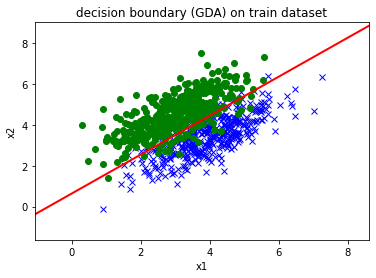

In [179]:
plot(x_train, y_train, real_thetas, title = "decision boundary (GDA) on train dataset")

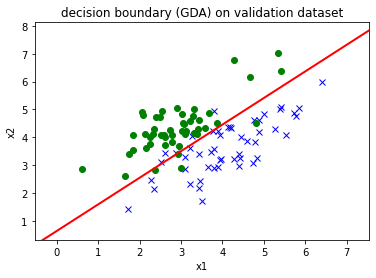

In [180]:
plot(x_val, y_val, real_thetas, title = "decision boundary (GDA) on validation dataset")